# Region-scale glacier analysis


The previous notebook demonstrated using xarray to analyze surface velocity data for an individual glacier. This notebook will show how we can examine spatial variability in surface velocity within a group of glaciers. To do this we will use **xarray** as well as **geopandas**, **geocube**, and **pandas**. We will start by using `.make_geocube()` to rasterize a vector object in the shape of an **ITS_LIVE** velocity raster object. We will then use the rasterized vector to group the **ITS_LIVE** object by individual glaciers and then calculate summary statistics of surface velocity for each glacier. The goal in this work flow is to end up with a **pandas dataframe** where each row is an individual glacier and columns for various surface velocity summary statistics. 

*Learning goals:*
- rasterizing vector data
- organizing and re-arranging data with xarray
- `.groupby()` for zonal statistics
- converting from xarray to pandas

In [1]:
import os
import json
import urllib.request
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from shapely.geometry import Polygon
from shapely.geometry import Point
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import cartopy.feature as cfeature

from geocube.api.core import make_geocube

%config InlineBackend.figure_format='retina'

In [2]:
import itslivetools

## Accessing ITS_LIVE data

In [3]:
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url_catalog:
    itslive_catalog = json.loads(url_catalog.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

In [4]:
url = itslivetools.find_granule_by_point(itslive_catalog, [95.180191, 30.645973])
url

['http://its-live-data.s3.amazonaws.com/datacubes/v02/N30E090/ITS_LIVE_vel_EPSG32646_G0120_X750000_Y3350000.zarr']

In [5]:
dc = itslivetools.read_in_s3(url[0])
dc

<xarray.Dataset>
Dimensions:                    (mid_date: 6554, y: 833, x: 833)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2021-05-13T04:30:01....
  * x                          (x) float64 7.001e+05 7.003e+05 ... 8e+05
  * y                          (y) float64 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(6554,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(6554,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(6554,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(6554, 70, 70), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(6554, 70, 70), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(6554,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(6554,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(6554,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(6554,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(6554,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(6554,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(6554,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 09:28:39
    date_updated:               09-Jun-2022 09:28:39
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N30E090/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N30E090/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The `mid_date` dimension of the `dc` object isn't in chronlogical order, so let's sort by this dimension:

In [6]:
dc = dc.sortby('mid_date')

In [7]:
crs = f'EPSG:{dc.projection}'
crs

'EPSG:32646'

## Vector data 

In [8]:
se_asia = gpd.read_file('https://github.com/e-marshall/itslive/raw/master/rgi15_southasiaeast.geojson')
se_asia.head(3)

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00001,G102044E29941N,19990920,-9999999,102.044042,29.941000,15,3,0.438,4996,...,251,850,0,0,0,0,9,9,NaN,"POLYGON ((102.03759 29.93828, 102.03759 29.938..."
1,RGI60-15.00002,G102042E29987N,19990920,-9999999,102.042346,29.987019,15,3,0.644,4947,...,244,1021,0,0,0,0,9,9,NaN,"POLYGON ((102.04195 29.99030, 102.04197 29.990..."
2,RGI60-15.00003,G102041E29997N,19990920,-9999999,102.041130,29.997311,15,3,0.225,5019,...,274,812,0,0,0,0,9,9,NaN,"POLYGON ((102.03710 29.99774, 102.03719 29.998..."


How many glaciers are in this dataframe?

In [9]:
se_asia['RGIId'].nunique()

3383

What coordinate reference system is this dataframe in? 

In [10]:
se_asia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The vector dataset is in WGS 84, meaning that its coordinates are in degrees latitude and longitude rather than meters N and E. We will project this dataset to match the projection of the netcdf dataset.

## Handling projections

Let's project this dataframe to match the CRS of the itslive dataset

In [11]:
#project rgi data to match itslive
se_asia_prj = se_asia.to_crs(crs) #we know the epsg from the projection variable of the dc object
se_asia_prj.head(3)

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00001,G102044E29941N,19990920,-9999999,102.044042,29.941000,15,3,0.438,4996,...,251,850,0,0,0,0,9,9,NaN,"POLYGON ((1374020.425 3346529.677, 1374020.310..."
1,RGI60-15.00002,G102042E29987N,19990920,-9999999,102.042346,29.987019,15,3,0.644,4947,...,244,1021,0,0,0,0,9,9,NaN,"POLYGON ((1373982.555 3352363.858, 1373984.703..."
2,RGI60-15.00003,G102041E29997N,19990920,-9999999,102.041130,29.997311,15,3,0.225,5019,...,274,812,0,0,0,0,9,9,NaN,"POLYGON ((1373445.407 3353156.074, 1373450.587..."


Give each glacier (row) a unique integer key that is related to that glacier's RGIId. We will use this later. Be careful that the `RGI_int` column is composed of **integers** not strings.

In [12]:
se_asia_prj['RGI_int'] = se_asia_prj['RGIId'].str.slice(9,).replace('.','_')
se_asia_prj['RGI_int'] = se_asia_prj.RGI_int.apply(lambda x: int('15' + x))
se_asia_prj.RGI_int.dtype

dtype('int64')

To start with, we will look only at glaciers larger in area than 5km2. Subset the dataset to select for those glaciers

In [13]:
se_asia_prj = se_asia_prj.loc[se_asia_prj['Area'] > 5.]
se_asia_prj.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int
185,RGI60-15.00186,G099434E30654N,20020113,-9999999,99.433808,30.653638,15,3,7.214,4802,...,4777,0,0,0,0,9,9,NaN,"POLYGON ((1117230.262 3410667.898, 1117265.509...",1500186
233,RGI60-15.00234,G097476E28353N,20000927,-9999999,97.475654,28.352548,15,3,8.507,4372,...,5000,0,0,0,0,9,9,NaN,"POLYGON ((939962.250 3142812.410, 939909.404 3...",1500234
367,RGI60-15.00368,G098674E28425N,20011203,-9999999,98.674072,28.425392,15,3,8.219,3165,...,8634,0,0,0,0,9,9,NaN,"POLYGON ((1058304.715 3158456.550, 1058381.685...",1500368
405,RGI60-15.00406,G098182E28652N,20011203,-9999999,98.181747,28.651985,15,3,7.800,4544,...,5205,0,0,0,0,9,9,NaN,"POLYGON ((1009141.937 3177946.948, 1009112.063...",1500406
502,RGI60-15.00503,G098653E28454N,20011203,-9999999,98.652981,28.453739,15,3,7.006,3917,...,9013,0,0,0,0,9,9,NaN,"POLYGON ((1055479.016 3162736.584, 1055469.623...",1500503


Next, want to subset the RGI dataset by the spatial extent of the ITS_LIVE data.
First, get the bbox of the ITS_LIVE data as a vector

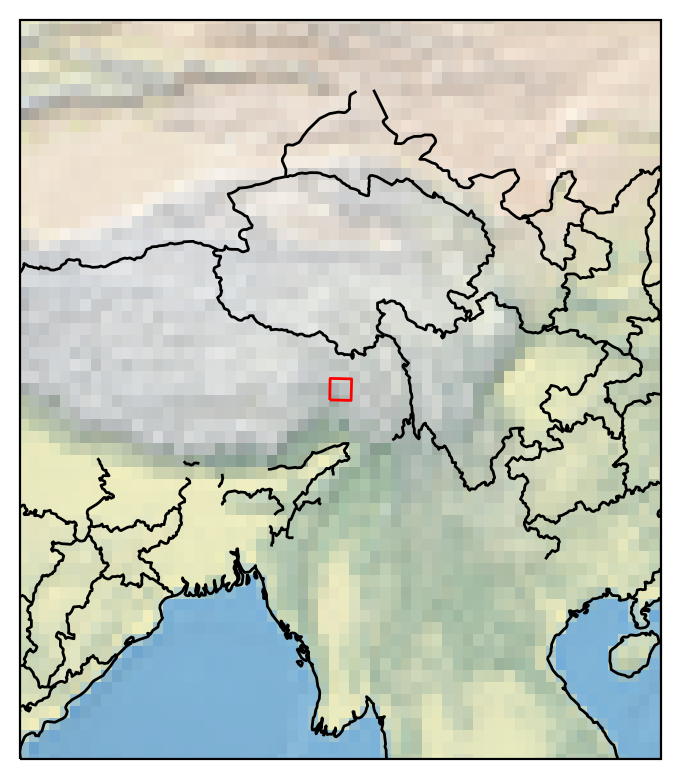

In [14]:
dc_bbox = itslivetools.get_bbox_single(dc)

Project it to local UTM to match the RGI geodataframe and extract the coordinate values from the geometry column

In [15]:
dc_bbox_prj = dc_bbox.to_crs(crs)


## Rasterize vector

Subset RGI dataset:
To do this we will use a [spatial join](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html). Here we use an `inner join` but there are various methods to customize the spatial join operation. Find more info [here](https://geopandas.org/en/stable/gallery/spatial_joins.html). 

In [16]:
rgi_sub = gpd.sjoin(se_asia_prj, dc_bbox_prj, how='inner')
# need to set the type as string here bc for some reason its object intead of str
rgi_sub["RGIId"] = rgi_sub.RGIId.astype("string")
rgi_sub.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int,index_right
620,RGI60-15.00621,G095088E30322N,19990923,-9999999,95.088364,30.321632,15,3,45.973,3432,...,0,0,0,0,9,9,NaN,"POLYGON ((704603.054 3353787.635, 704618.934 3...",1500621,0
638,RGI60-15.00639,G095180E30646N,19990923,-9999999,95.180191,30.645973,15,3,8.688,4744,...,0,0,0,0,9,9,NaN,"POLYGON ((709916.300 3391462.613, 709882.915 3...",1500639,0
641,RGI60-15.00642,G095206E30632N,19990923,-9999999,95.205750,30.631853,15,3,6.801,4697,...,0,0,0,0,9,9,NaN,"POLYGON ((712314.578 3391472.930, 712355.266 3...",1500642,0
654,RGI60-15.00655,G095323E30633N,19990923,-9999999,95.323348,30.633339,15,3,5.284,4979,...,0,0,0,0,9,9,NaN,"POLYGON ((724381.841 3390545.667, 724380.953 3...",1500655,0
834,RGI60-15.00835,G095642E30308N,19990923,-9999999,95.642175,30.308182,15,3,5.747,4454,...,0,0,0,0,9,9,NaN,"POLYGON ((756119.478 3353815.541, 756063.500 3...",1500835,0


In [73]:
rgi_sub['RGIId'].values

<StringArray>
['RGI60-15.00621', 'RGI60-15.00639', 'RGI60-15.00642', 'RGI60-15.00655',
 'RGI60-15.00835', 'RGI60-15.00850', 'RGI60-15.00872', 'RGI60-15.00885',
 'RGI60-15.00898', 'RGI60-15.00899', 'RGI60-15.00957', 'RGI60-15.01004',
 'RGI60-15.01024', 'RGI60-15.01077', 'RGI60-15.01078', 'RGI60-15.01102',
 'RGI60-15.01107', 'RGI60-15.01127', 'RGI60-15.01181', 'RGI60-15.01182',
 'RGI60-15.01262']
Length: 21, dtype: string

Write crs of dc object:

In [18]:
dc = dc.rio.write_crs(crs, inplace=True)

In [19]:
rgi_sub = rgi_sub.drop('index_right', axis=1)

In [20]:
len(rgi_sub['RGIId']) # number of glaciers in the subset

21

Now, use the `.make_geocube()` function. This essentially takes a vector object (`rgi_sub`) and rasterizes it, returning an xarray object with the same structure as the object you provide for the `like =` argument (in our case that is `dc`). This example relies greatly on the [zonal statistics example](https://corteva.github.io/geocube/html/examples/zonal_statistics.html) in the **geocube** documentation, which contains additional helpful details. 

In [21]:
out_grid = make_geocube(
    vector_data = rgi_sub,
    measurements = ["RGI_int"],
    like = dc
)
out_grid

<xarray.Dataset>
Dimensions:      (y: 833, x: 833)
Coordinates:
  * y            (y) float64 3.4e+06 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06 3.3e+06
  * x            (x) float64 7.001e+05 7.003e+05 7.004e+05 ... 7.999e+05 8e+05
    spatial_ref  int64 0
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

Now each glacier in the geodataframe `rgi_sub` has been coded with a unique integer value that corresponds to that glacier's Randolph Glacier Inventory ID. 

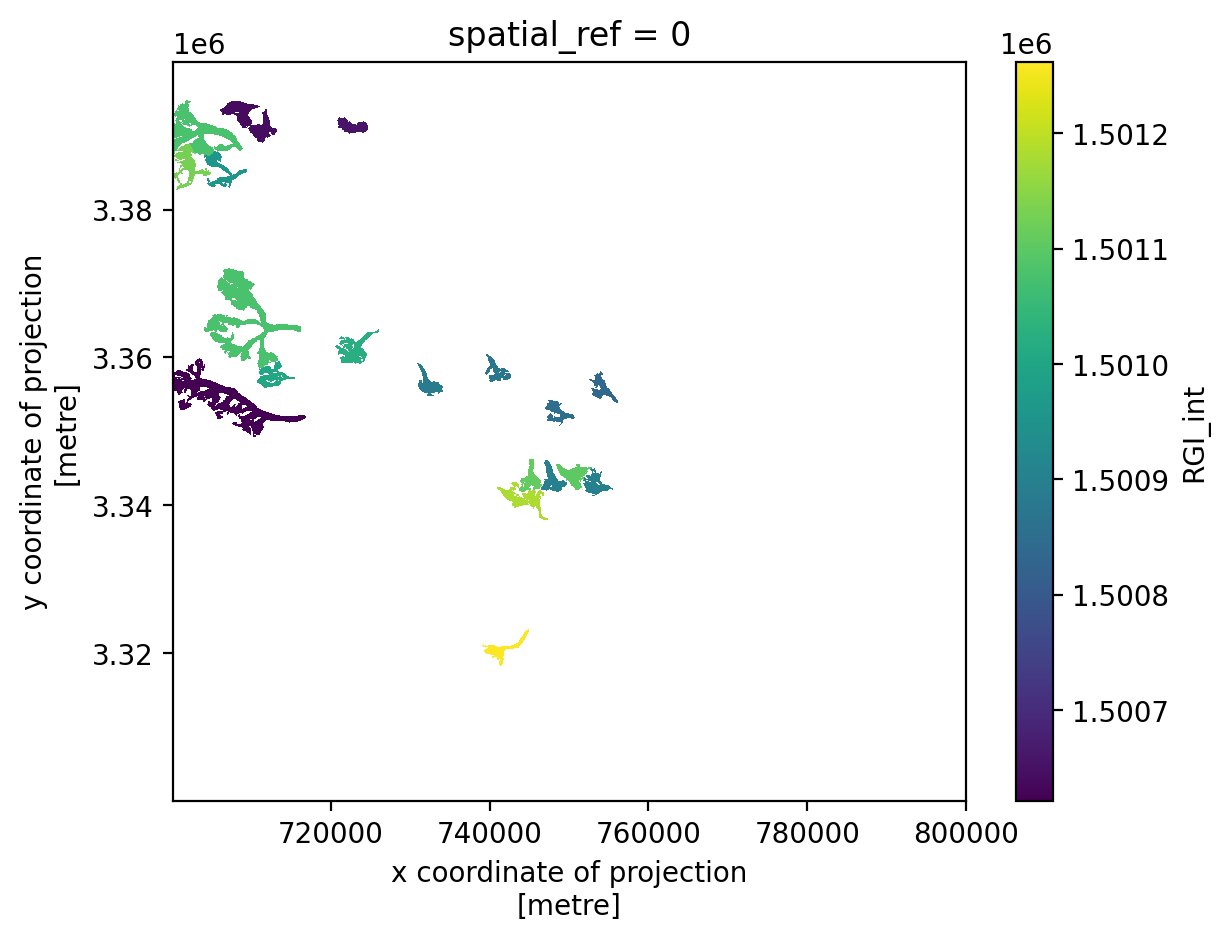

In [22]:
out_grid.RGI_int.plot()

Next, merge the rasterized vector and the dataset containing the velocity data into an xarray dataset:

In [74]:
out_grid['v'] = dc.v.mean(dim='mid_date')
out_grid

<xarray.Dataset>
Dimensions:      (y: 833, x: 833, mid_date: 6554)
Coordinates:
  * y            (y) float64 3.4e+06 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06 3.3e+06
  * x            (x) float64 7.001e+05 7.003e+05 7.004e+05 ... 7.999e+05 8e+05
    spatial_ref  int64 0
    mapping      int64 0
  * mid_date     (mid_date) datetime64[ns] 2013-06-17T04:12:21.030095104 ... ...
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    v            (y, x) float32 dask.array<chunksize=(70, 70), meta=np.ndarray>

In [75]:
out_grid

<xarray.Dataset>
Dimensions:      (y: 833, x: 833, mid_date: 6554)
Coordinates:
  * y            (y) float64 3.4e+06 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06 3.3e+06
  * x            (x) float64 7.001e+05 7.003e+05 7.004e+05 ... 7.999e+05 8e+05
    spatial_ref  int64 0
    mapping      int64 0
  * mid_date     (mid_date) datetime64[ns] 2013-06-17T04:12:21.030095104 ... ...
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    v            (y, x) float32 dask.array<chunksize=(70, 70), meta=np.ndarray>

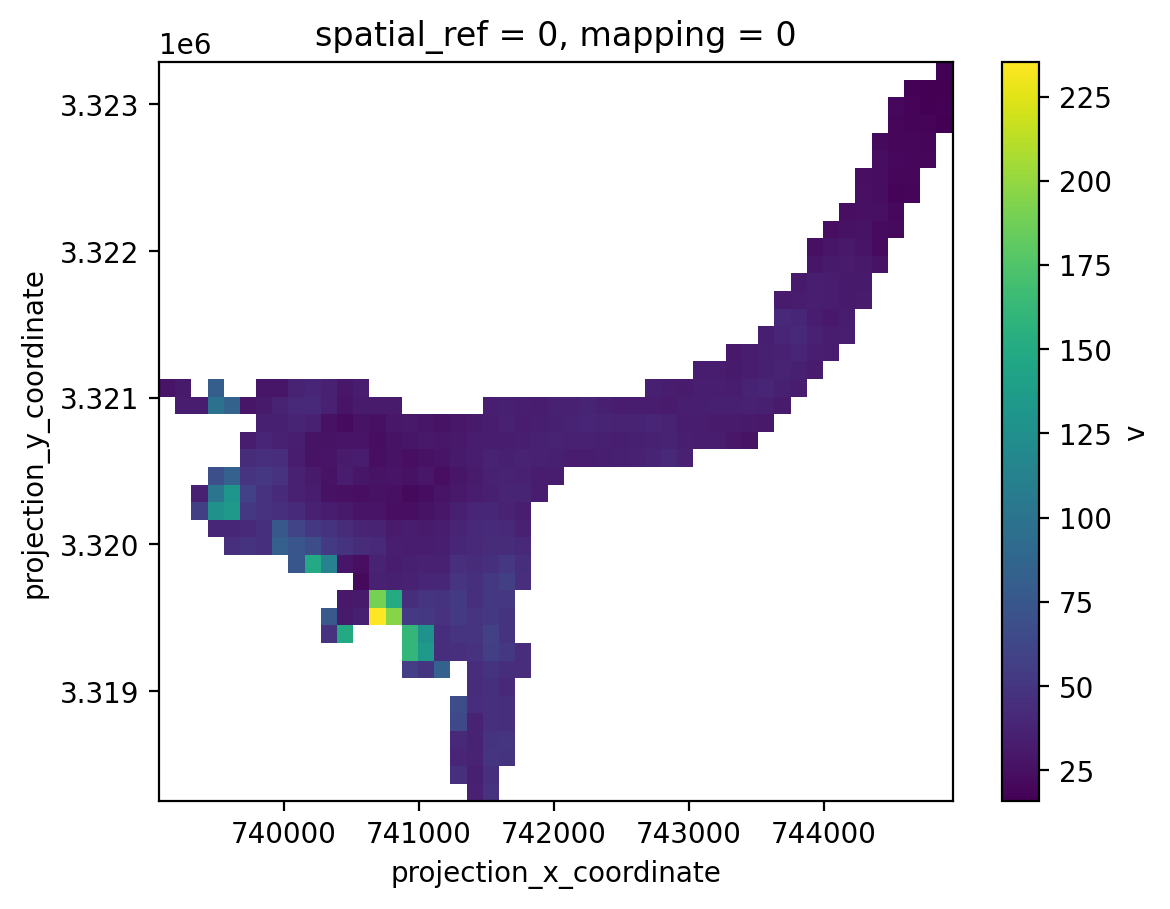

In [76]:
out_grid.where(out_grid.RGI_int == 1501262, drop=True).isel(mid_date=slice(1,100)).v.plot()

Since we are mostly interested in examining spatial variability, let's take a temporal subset of the dataset to make the computation faster: 

In [77]:
out_grid_sub = out_grid.sel(mid_date = slice('2015-01-01','2015-02-01'))
out_grid_sub

<xarray.Dataset>
Dimensions:      (y: 833, x: 833, mid_date: 12)
Coordinates:
  * y            (y) float64 3.4e+06 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06 3.3e+06
  * x            (x) float64 7.001e+05 7.003e+05 7.004e+05 ... 7.999e+05 8e+05
    spatial_ref  int64 0
    mapping      int64 0
  * mid_date     (mid_date) datetime64[ns] 2015-01-06T04:10:27.530095104 ... ...
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    v            (y, x) float32 dask.array<chunksize=(70, 70), meta=np.ndarray>

Now, we will use `.groupby()` to group the dataset by the RGI ID:

In [27]:
#grouped_ID = out_grid_sub.drop('spatial_ref').groupby(out_grid_sub['RGI_int'])
grouped_ID = out_grid_sub.groupby(out_grid_sub['RGI_int'])

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [72]:
rgi_sub[['RGIId','RGI_int']]

,RGIId,RGI_int
620,RGI60-15.00621,1500621
638,RGI60-15.00639,1500639
641,RGI60-15.00642,1500642
654,RGI60-15.00655,1500655
834,RGI60-15.00835,1500835
849,RGI60-15.00850,1500850
871,RGI60-15.00872,1500872
884,RGI60-15.00885,1500885
897,RGI60-15.00898,1500898
898,RGI60-15.00899,1500899


and compute summary statistics for a single variable on the grouped object:

In [79]:
grid_mean_sp = grouped_ID.mean().rename({'v': 'speed_mean'})
#grid_min_sp = grouped_ID.min(dim='mid_date').rename({'v': 'speed_min'})
#grid_max_sp = grouped_ID.max(dim='mid_date').rename({'v': 'speed_max'})
    

MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'RGI_int'}

Check if the data arrays (`RGI_int`) are equal, must be the case for `xr.merge()` in next step

In [30]:
#grid_mean_sp.RGI_int.equals([grid_max_sp.RGI_int, grid_min_sp.RGI_int])
grid_mean_sp.RGI_int.equals(grid_min_sp.RGI_int)
grid_mean_sp.RGI_int.equals(grid_max_sp.RGI_int)
grid_min_sp.RGI_int.equals(grid_max_sp.RGI_int)

True

Merge and convert the lazy object to an in-memory equivalent usind dask [`.compute()`](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.compute.html). Once it is in-memory, we can convert it to a pandas dataframe.

In [56]:
zonal_stats = xr.merge([grid_mean_sp, grid_min_sp, grid_max_sp]).compute()


In [57]:
zonal_stats_df = zonal_stats.to_dataframe()

In [60]:
zonal_stats_df = zonal_stats_df.reset_index()

In [62]:
zonal_stats_df = zonal_stats_df.drop(['mapping','spatial_ref'], axis=1)
zonal_stats_df

,y,x,RGI_int,speed_mean,speed_min,speed_max
0,3399907.5,700132.5,NaN,73.800003,42.0,126.0
1,3399907.5,700252.5,NaN,65.800003,34.0,114.0
2,3399907.5,700372.5,NaN,50.000000,17.0,110.0
3,3399907.5,700492.5,NaN,77.250000,21.0,157.0
4,3399907.5,700612.5,NaN,33.200001,26.0,47.0
...,...,...,...,...,...,...
693884,3300067.5,799492.5,NaN,14.916667,1.0,53.0
693885,3300067.5,799612.5,NaN,28.000000,2.0,120.0
693886,3300067.5,799732.5,NaN,14.083333,0.0,32.0
693887,3300067.5,799852.5,NaN,22.916666,1.0,69.0


In [64]:
zonal_stats_df[zonal_stats_df['RGI_int'].notna()]

,y,x,RGI_int,speed_mean,speed_min,speed_max
35833,3394747.5,701812.5,1501077.0,28.666666,4.0,64.0
35834,3394747.5,701932.5,1501077.0,31.166666,14.0,52.0
36665,3394627.5,701692.5,1501077.0,22.333334,4.0,41.0
36666,3394627.5,701812.5,1501077.0,33.333332,11.0,66.0
36667,3394627.5,701932.5,1501077.0,27.833334,10.0,50.0
...,...,...,...,...,...,...
565950,3318427.5,741292.5,1501262.0,38.333332,9.0,81.0
565951,3318427.5,741412.5,1501262.0,42.333332,8.0,100.0
565952,3318427.5,741532.5,1501262.0,94.000000,94.0,94.0
566784,3318307.5,741412.5,1501262.0,37.666668,6.0,96.0


Make a new object where you merge the `zonal_stats` object by RGI ID and filter out any glaciers smaller than 5 square kilometers:

In [45]:
zonal_stats

,y,x,RGI_int,speed_mean,speed_min,speed_max
0,3399907.5,700132.5,NaN,73.800003,42.0,126.0
1,3399907.5,700252.5,NaN,65.800003,34.0,114.0
2,3399907.5,700372.5,NaN,50.000000,17.0,110.0
3,3399907.5,700492.5,NaN,77.250000,21.0,157.0
4,3399907.5,700612.5,NaN,33.200001,26.0,47.0
...,...,...,...,...,...,...
693884,3300067.5,799492.5,NaN,14.916667,1.0,53.0
693885,3300067.5,799612.5,NaN,28.000000,2.0,120.0
693886,3300067.5,799732.5,NaN,14.083333,0.0,32.0
693887,3300067.5,799852.5,NaN,22.916666,1.0,69.0


In [43]:
rgi_itslive = rgi_sub.loc[rgi_sub['Area'] > 5.]

In [44]:
rgi_itslive

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int
620,RGI60-15.00621,G095088E30322N,19990923,-9999999,95.088364,30.321632,15,3,45.973,3432,...,19592,0,0,0,0,9,9,NaN,"POLYGON ((704603.054 3353787.635, 704618.934 3...",1500621
638,RGI60-15.00639,G095180E30646N,19990923,-9999999,95.180191,30.645973,15,3,8.688,4744,...,5149,0,0,0,0,9,9,NaN,"POLYGON ((709916.300 3391462.613, 709882.915 3...",1500639
641,RGI60-15.00642,G095206E30632N,19990923,-9999999,95.205750,30.631853,15,3,6.801,4697,...,4804,0,0,0,0,9,9,NaN,"POLYGON ((712314.578 3391472.930, 712355.266 3...",1500642
654,RGI60-15.00655,G095323E30633N,19990923,-9999999,95.323348,30.633339,15,3,5.284,4979,...,2643,0,0,0,0,9,9,NaN,"POLYGON ((724381.841 3390545.667, 724380.953 3...",1500655
834,RGI60-15.00835,G095642E30308N,19990923,-9999999,95.642175,30.308182,15,3,5.747,4454,...,5136,0,0,0,0,9,9,NaN,"POLYGON ((756119.478 3353815.541, 756063.500 3...",1500835
849,RGI60-15.00850,G095583E30279N,19990923,-9999999,95.583310,30.279366,15,3,5.550,4467,...,4295,0,0,0,0,9,9,NaN,"POLYGON ((748888.210 3350674.658, 748872.707 3...",1500850
871,RGI60-15.00872,G095506E30331N,19990923,-9999999,95.505625,30.330679,15,3,5.243,4333,...,5059,0,0,0,0,9,9,NaN,"POLYGON ((740019.593 3357082.412, 739992.167 3...",1500872
884,RGI60-15.00885,G095416E30317N,19990923,-9999999,95.415893,30.317158,15,3,5.868,3759,...,5524,0,0,0,0,9,9,NaN,"POLYGON ((731853.279 3355223.112, 731807.569 3...",1500885
897,RGI60-15.00898,G095575E30197N,19990923,-9999999,95.575286,30.196550,15,3,6.095,4236,...,4840,0,0,0,0,9,9,NaN,"POLYGON ((747056.451 3342128.608, 747055.579 3...",1500898
898,RGI60-15.00899,G095631E30191N,19990923,-9999999,95.631189,30.191358,15,3,6.483,3958,...,4308,0,0,0,0,9,9,NaN,"POLYGON ((753835.001 3341646.189, 753831.944 3...",1500899


In [36]:
rgi_itslive['RGIId'].nunique()

21

<Axes: xlabel='Area', ylabel='speed_mean'>

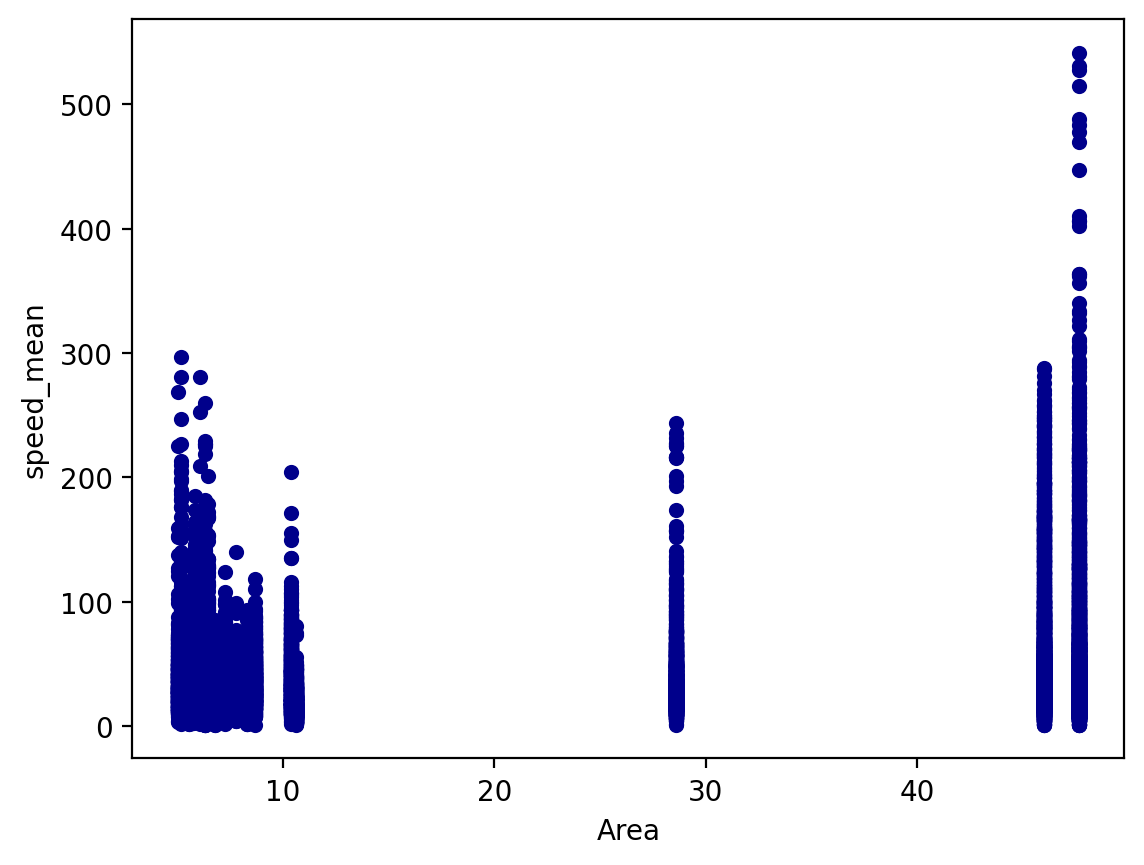

In [37]:
fig, ax = plt.subplots()
rgi_itslive.plot.scatter(x='Area',y = 'speed_mean', c = 'darkblue', ax=ax)


<Axes: >

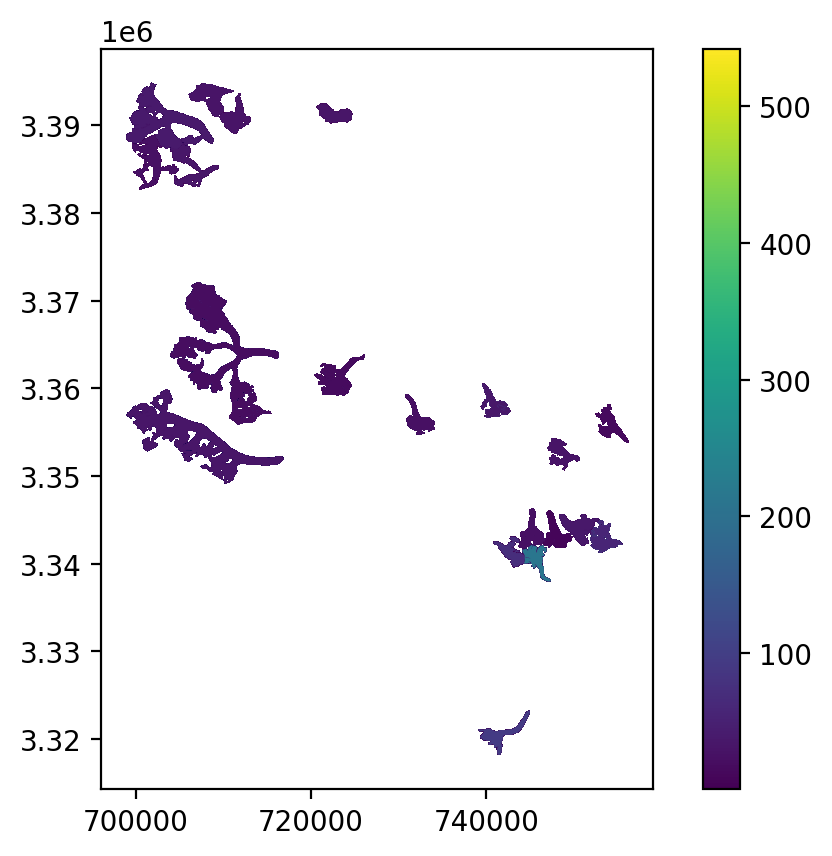

In [38]:
rgi_itslive.plot(column='speed_mean', legend=True)

In [39]:
rgi_itslive

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Surging,Linkages,Name,geometry,RGI_int,y,x,speed_mean,speed_min,speed_max
0,RGI60-15.00621,G095088E30322N,19990923,-9999999,95.088364,30.321632,15,3,45.973,3432,...,9,9,NaN,"POLYGON ((704603.054 3353787.635, 704618.934 3...",1500621,3359827.5,703492.5,30.571428,1.0,79.0
1,RGI60-15.00621,G095088E30322N,19990923,-9999999,95.088364,30.321632,15,3,45.973,3432,...,9,9,NaN,"POLYGON ((704603.054 3353787.635, 704618.934 3...",1500621,3359707.5,703252.5,28.571428,1.0,103.0
2,RGI60-15.00621,G095088E30322N,19990923,-9999999,95.088364,30.321632,15,3,45.973,3432,...,9,9,NaN,"POLYGON ((704603.054 3353787.635, 704618.934 3...",1500621,3359707.5,703372.5,17.142857,3.0,28.0
3,RGI60-15.00621,G095088E30322N,19990923,-9999999,95.088364,30.321632,15,3,45.973,3432,...,9,9,NaN,"POLYGON ((704603.054 3353787.635, 704618.934 3...",1500621,3359707.5,703492.5,14.142858,1.0,30.0
4,RGI60-15.00621,G095088E30322N,19990923,-9999999,95.088364,30.321632,15,3,45.973,3432,...,9,9,NaN,"POLYGON ((704603.054 3353787.635, 704618.934 3...",1500621,3359707.5,703612.5,12.285714,0.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16777,RGI60-15.01262,G095506E29992N,19990923,-9999999,95.506180,29.992268,15,3,6.324,3283,...,9,9,NaN,"POLYGON ((743746.580 3320885.694, 743673.033 3...",1501262,3318427.5,741292.5,38.333332,9.0,81.0
16778,RGI60-15.01262,G095506E29992N,19990923,-9999999,95.506180,29.992268,15,3,6.324,3283,...,9,9,NaN,"POLYGON ((743746.580 3320885.694, 743673.033 3...",1501262,3318427.5,741412.5,42.333332,8.0,100.0
16779,RGI60-15.01262,G095506E29992N,19990923,-9999999,95.506180,29.992268,15,3,6.324,3283,...,9,9,NaN,"POLYGON ((743746.580 3320885.694, 743673.033 3...",1501262,3318427.5,741532.5,94.000000,94.0,94.0
16780,RGI60-15.01262,G095506E29992N,19990923,-9999999,95.506180,29.992268,15,3,6.324,3283,...,9,9,NaN,"POLYGON ((743746.580 3320885.694, 743673.033 3...",1501262,3318307.5,741412.5,37.666668,6.0,96.0


In [40]:
#rgi_itslive.explore()

Awesome! We have encoded vector data onto a raster object that let's us examine raster data for multiple spatial units simultaneously. 